(60000, 784)
10000
313/313 [==============================] - 0s 1ms/step
(10000,)


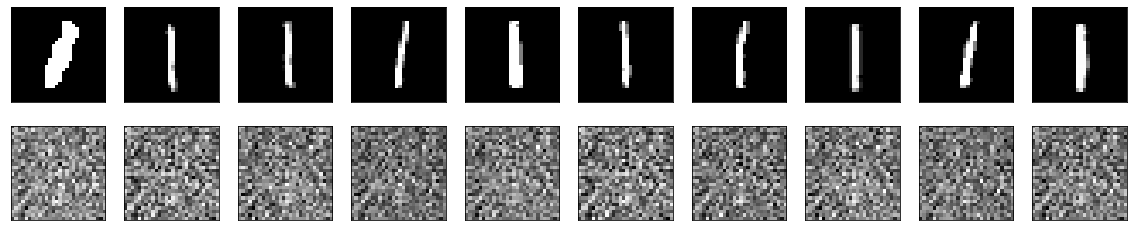

In [25]:
'''
PART - 1

Name : Aditya Pradip Kulkarni

'''

from keras.metrics.metrics import mean_squared_error
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is
#784 floats
# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)
# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(int(x_test.shape[0]))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test), verbose=0)
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


#Calculate the difference between the actual and decoded images
diff = np.absolute(x_test-decoded_imgs)

# Sum the difference
diff = np.sum(diff, axis = 1)

print(diff.shape)

# Get the top 10 maximun difference
indices = np.argsort(diff)

# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
n = 10 # how many digits we will display

plt.figure(figsize=(20, 4))
for i in range(n):
  # for reversed
  j = indices[len(indices)-1-i]
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[j].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[j].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Observation :
'''
1. Here, I have calculated using the Manhattan normalization method.

2. The model performance can be improved by adding the optimizer as adam

3. The generated images (decoded images) from the model consists of high noise.
'''


Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 235us/sample - loss: 478.1204
Epoch 2/10
60000/60000 [==============================] - 14s 232us/sample - loss: 428.2590
Epoch 3/10
60000/60000 [==============================] - 14s 235us/sample - loss: 427.4274
Epoch 4/10
60000/60000 [==============================] - 14s 234us/sample - loss: 427.4204
Epoch 5/10
60000/60000 [==============================] - 14s 232us/sample - loss: 427.4185
Epoch 6/10
60000/60000 [==============================] - 14s 232us/sample - loss: 427.4176
Epoch 7/10
60000/60000 [==============================] - 15s 256us/sample - loss: 427.4171
Epoch 8/10
60000/60000 [==============================] - 14s 235us/sample - loss: 427.4169
Epoch 9/10
60000/60000 [==============================] - 14s 230us/sample - loss: 427.4167
Epoch 10/10
60000/60000 [==============================] - 14s 229us/sample - loss: 427.4167


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


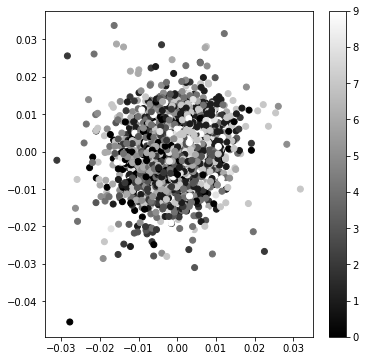

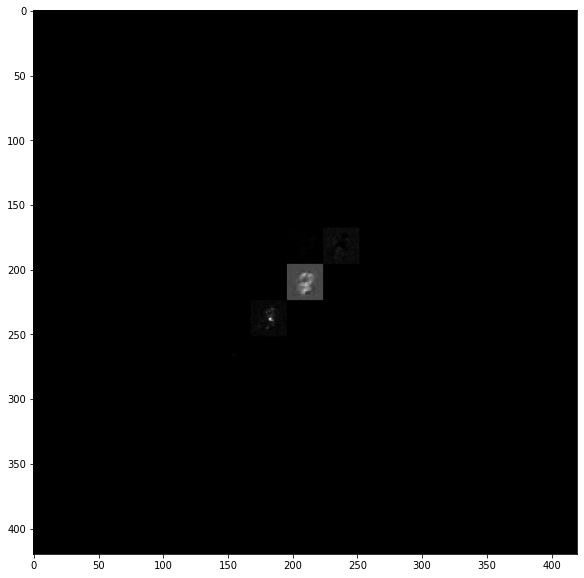

In [31]:
'''
PART - 3

'''

from tensorflow import *
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import *
from keras.callbacks import LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

# m : batch size
m = 50   
# n_z : latent dimension
n_z = 2
# n_epoch : number of epoches for iterations
n_epoch = 10
epsilon_std=1.0

# intermediate_dim = 512
# Q(z|X) -- encoder ======== ======== Modification done here

inputs = Input(shape=(784,))
h_q = Dense(512, activation='relu')(inputs)
h_q1=Dense(64,activation='relu')(h_q)
mu = Dense(n_z, activation='linear')(h_q1)
log_sigma = Dense(n_z, activation='linear')(h_q1)

def sample_z(args):
    mu, log_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=epsilon_std)
    return mu + K.exp(log_sigma / 2) * eps

# Sample z ~ Q(z|X)
z = Lambda(sample_z)([mu, log_sigma])

# P(X|z) -- decoder =========== ======== Modification done here

decoder_hidden1 = Dense(64,activation='relu')
decoder_hidden2 = Dense(512, activation='relu')
decoder_out = Dense(784, activation='sigmoid')
h_p = decoder_hidden2(z)
outputs = decoder_out(h_p)

# Overall VAE model, for reconstruction and training
vae = Model(inputs, outputs)

# Encoder model, to encode input into latent variable
# We use the mean as the output as it is the center point, the representative of 
#the gaussian

encoder = Model(inputs, mu)
# Generator model, generate new data given latent variable z
d_in = Input(shape=(n_z,))
d_h = decoder_hidden2(d_in)
d_out = decoder_out(d_h)
generator = Model(d_in, d_out)

def vae_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for each data in minibatch 
"""
    # E[log P(X|z)]
    recon = K.sum(K.binary_crossentropy(y_pred, y_true), axis=1)
    # D_KL(Q(z|X) || P(z|X)); calculate in closed form as both dist. are Gaussian
    kl = 0.5 * K.sum(K.exp(log_sigma) + K.square(mu) - 1. - log_sigma, axis=1)
    return recon + kl

from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, y_test) = mnist.load_data()
# In[13]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(x_train, x_train, batch_size=m, epochs=n_epoch)

x_test_encoded = encoder.predict(x_test, batch_size=m)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * 2.0
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()
